In [77]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import autograd

In [78]:
# Set seeds for reproducibility:
torch.manual_seed(1234)

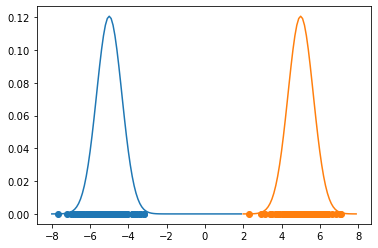

In [79]:
# Generate a dataset by sampling from two different normal distributions:
data = torch.concat((torch.normal(size=(100,1), mean = -5, std = 1), torch.normal(size=(100,1), mean=5, std = 1)))

fig = plt.figure()
ax = fig.gca()
ax.scatter(data.detach().numpy()[0:100], np.zeros(shape = (100,1)))
ax.scatter(data.detach().numpy()[100:200], np.zeros(shape = (100,1)))
ax.plot(np.arange(-8,2,0.1), 10**torch.distributions.normal.Normal(-5,1).log_prob(torch.arange(-8,2,0.1)).detach().numpy())
ax.plot(np.arange(2,8,0.1), 10**torch.distributions.normal.Normal(5,1).log_prob(torch.arange(2,8,0.1)).detach().numpy())
plt.show()


In [80]:
# Create a discriminator/critic class:
class Discriminator(nn.Module):
    
    def __init__(self):
        
        super(Discriminator,self).__init__()

        self.forw = nn.Sequential( 
            nn.Linear(in_features=1,out_features=100),
            #nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(in_features=100,out_features=50),
            #nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Linear(in_features=50,out_features=10),
            #nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=1),
            nn.Sigmoid(),
        )
    
    def forward(self, input):

        return self.forw(input)

# Create a discriminator/critic class:
class Discriminator_WGAN(nn.Module):
    
    def __init__(self):
        
        super(Discriminator_WGAN,self).__init__()

        self.forw = nn.Sequential( 
            nn.Linear(in_features=1,out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100,out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=1),
        )
    
    def forward(self, input):

        return self.forw(input)


In [81]:
# Create instance of a model:
discriminator_gan = Discriminator()
# Copy all parameter values from above but remove the sigmoid layer:
discriminator_wgan = Discriminator_WGAN()
#discriminator_wgan.load_state_dict(discriminator_gan.state_dict())
discriminator_wgan_gp = Discriminator_WGAN()
#discriminator_wgan_gp.load_state_dict(discriminator_gan.state_dict())

def weights_init_disc_gan(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 1)
        m.bias.data.fill_(0.1)

def weights_init_disc_wgan(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.1)
        m.bias.data.fill_(0.1)

def weights_init_disc_wgan_gp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 1)
        m.bias.data.fill_(0.1)

discriminator_gan.apply(weights_init_disc_gan)
discriminator_wgan.apply(weights_init_disc_wgan)
discriminator_wgan_gp.apply(weights_init_disc_wgan_gp)

Discriminator_WGAN(
  (forw): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [82]:
### Core part: Use different Loss Functions
# "Normal" GAN:
bce = nn.BCELoss()
opt_disc_gan = torch.optim.Adam(params = discriminator_gan.parameters(), lr = 0.0005, betas = (0.5, 0.9))
#, betas = (0.5,0.9))
# WGAN: loss defined below
opt_disc_wgan = torch.optim.Adam(params = discriminator_wgan.parameters(), lr = 0.001, betas = (0.5,0.9))
# WGAN-GP: loss defined below
opt_disc_wgan_gp = torch.optim.Adam(params = discriminator_wgan_gp.parameters(), lr = 0.001, betas = (0.5,0.9))


##############################
### Define Wasserstein loss function:
### IMPORTANT: Pytorch minimizes --> (-1)*function
##############################
def wlossGrad(dx_hat_grad):
    
    return 10*((dx_hat_grad.norm(2, dim=1) - 1) ** 2).mean()

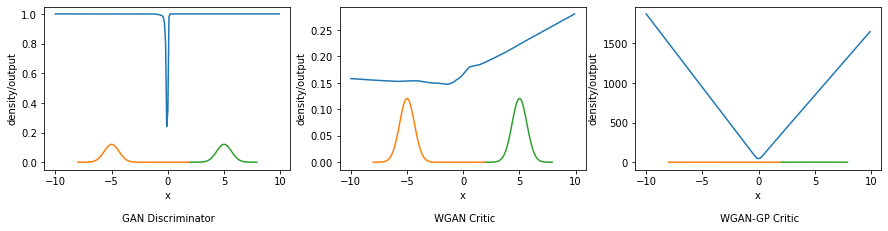

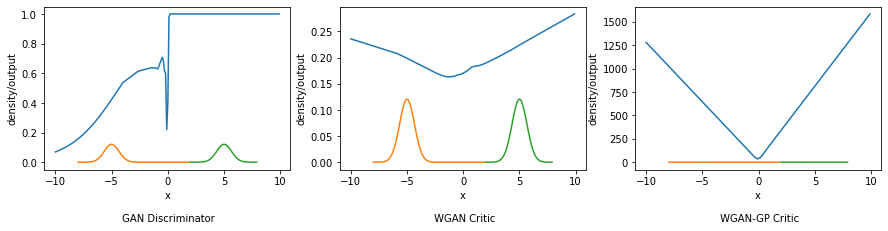

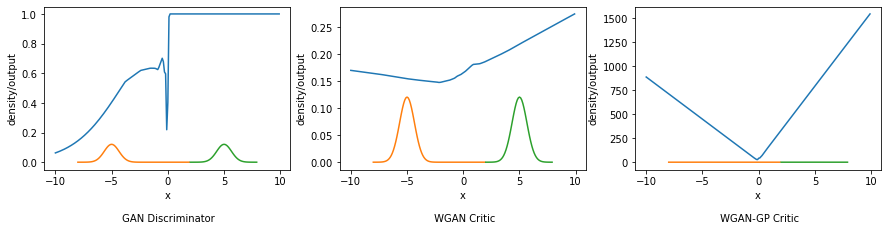

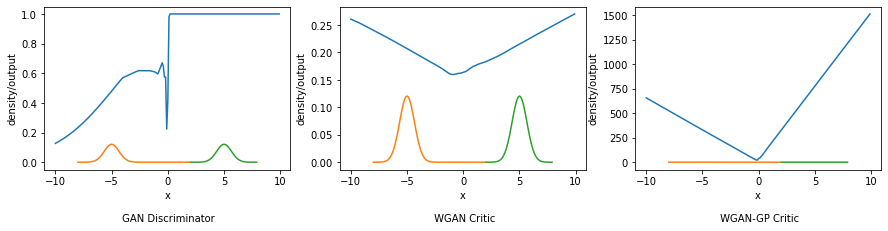

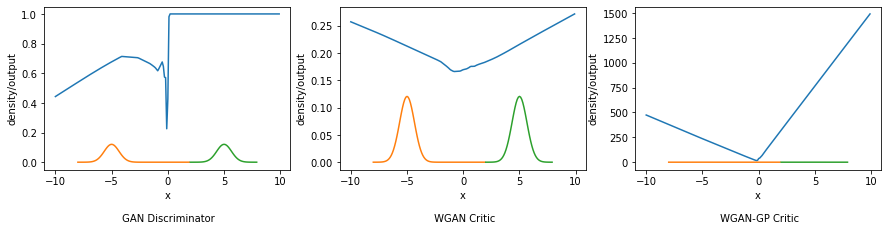

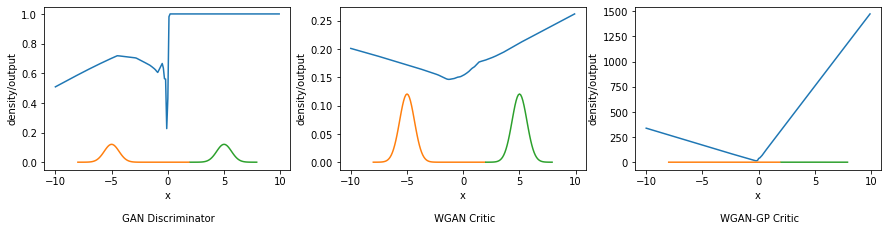

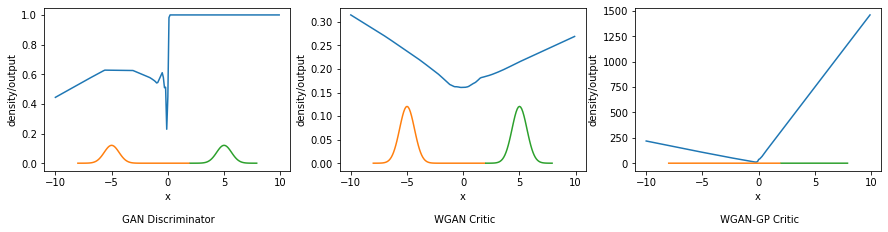

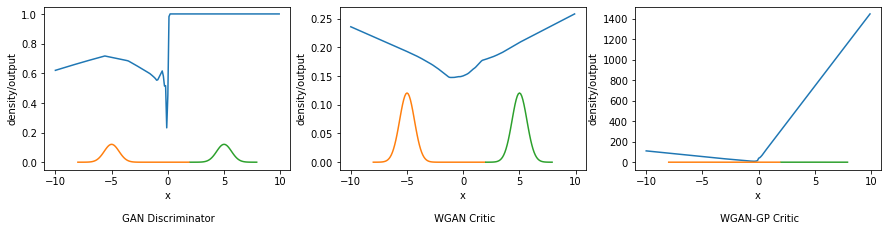

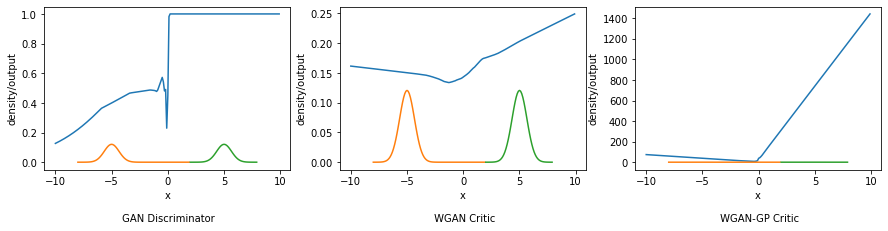

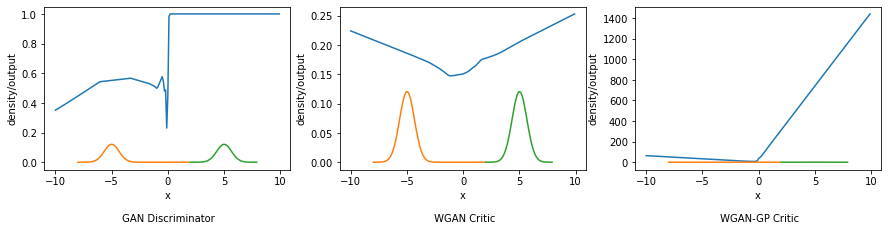

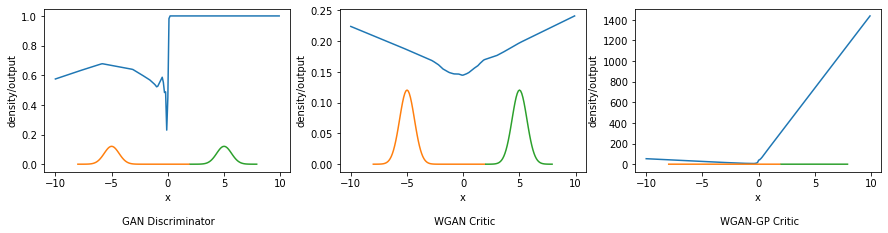

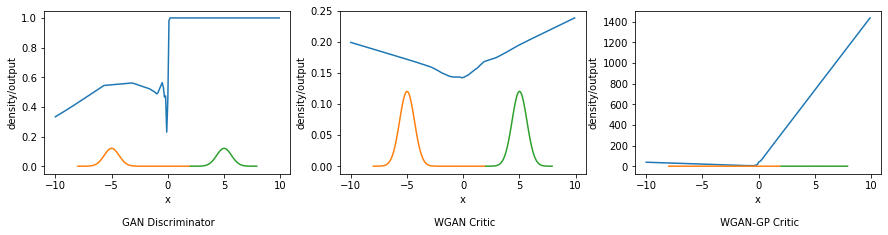

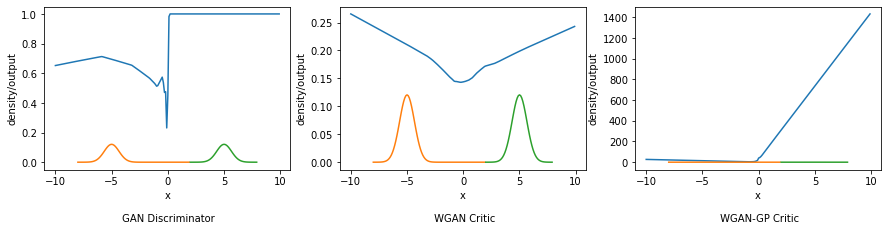

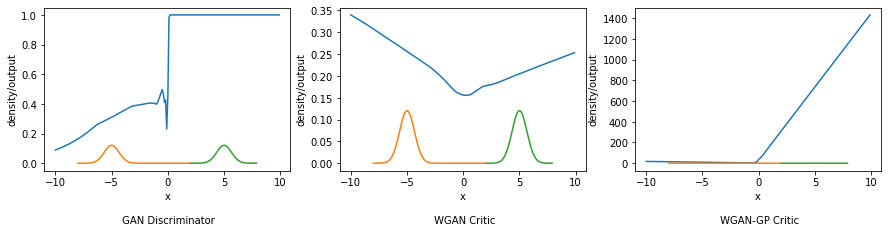

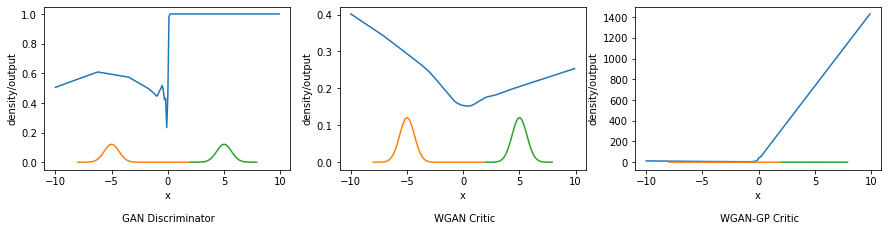

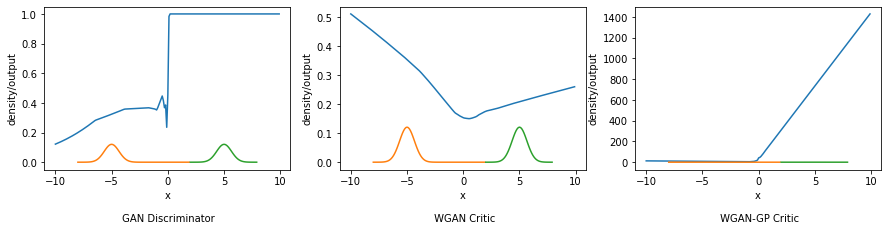

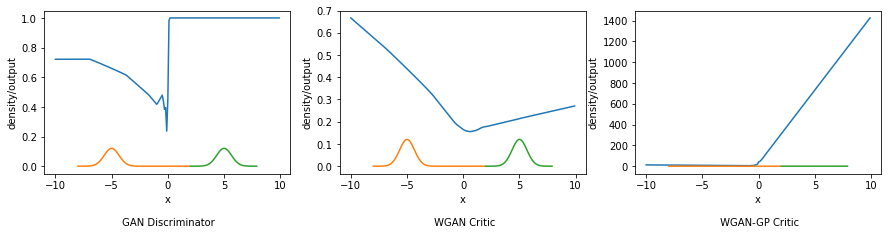

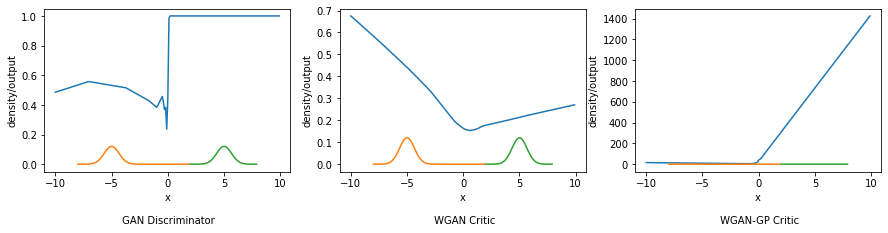

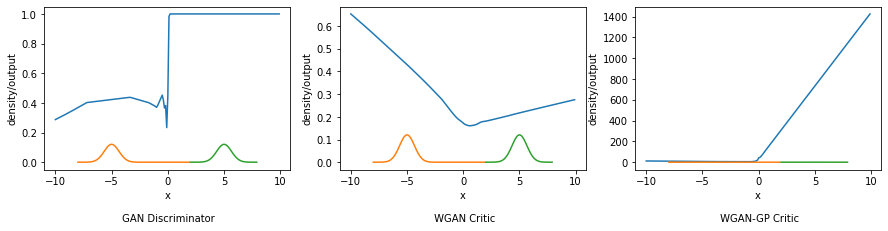

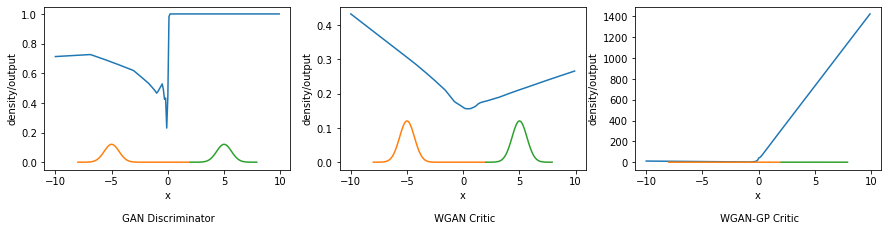

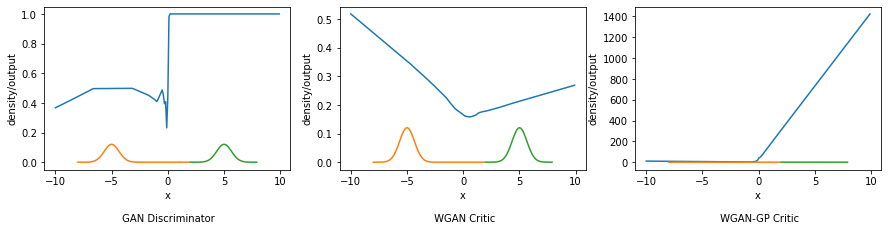

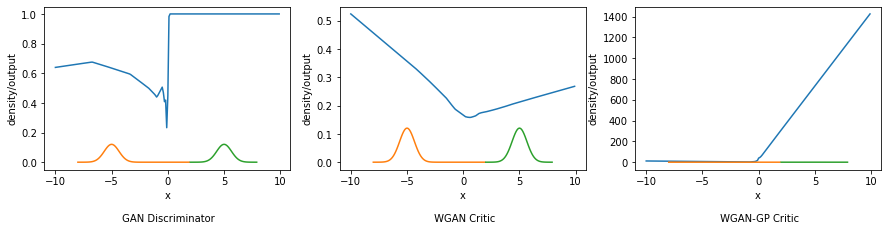

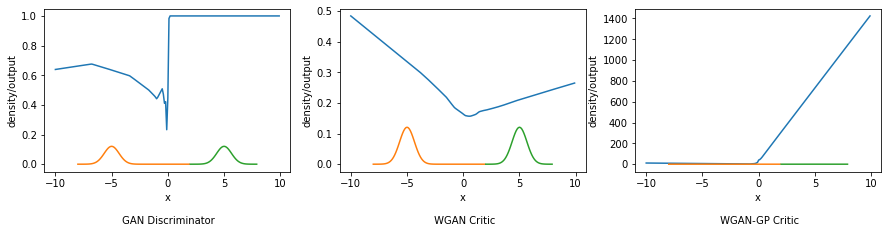

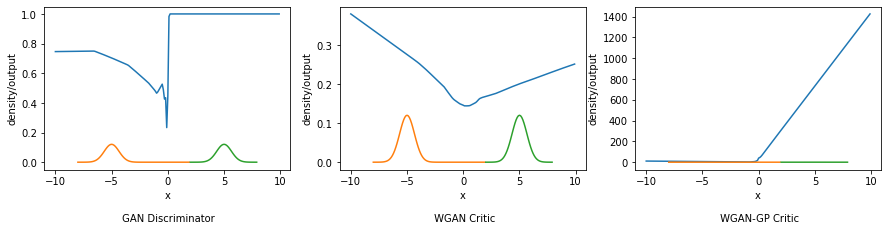

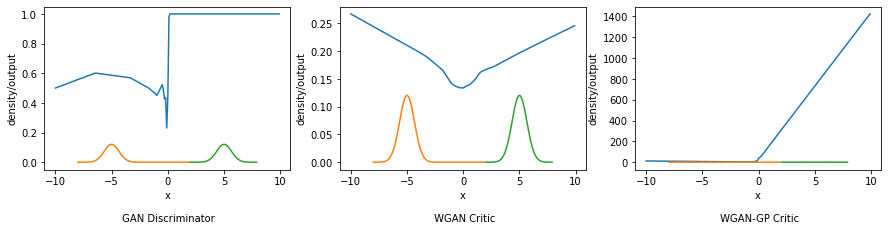

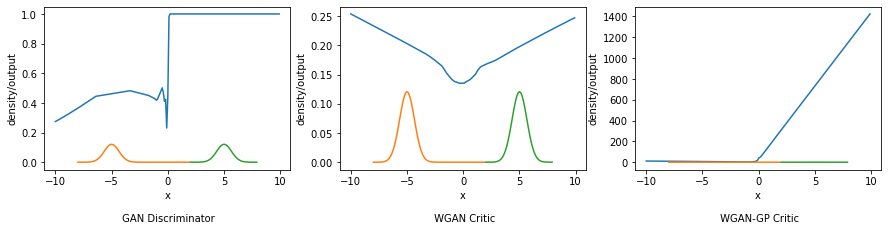

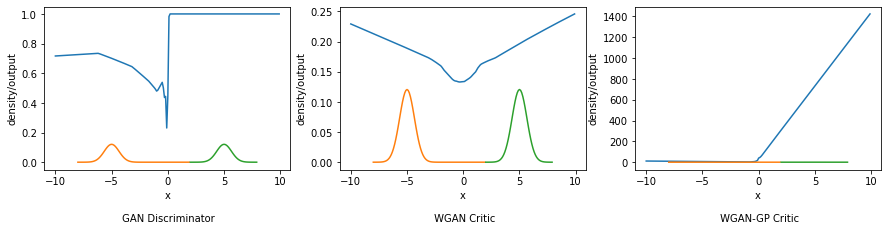

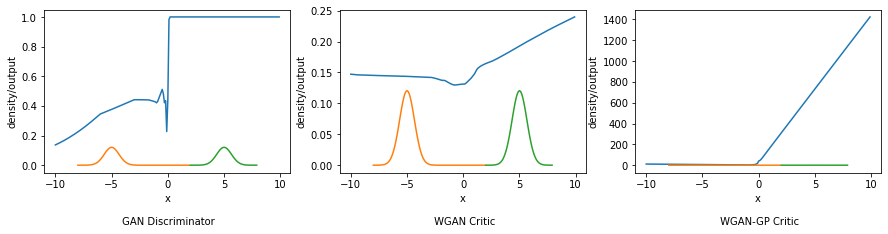

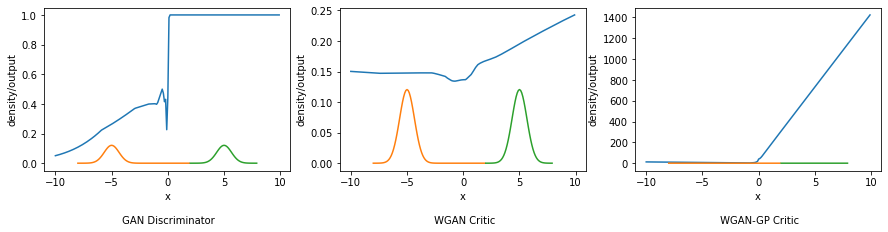

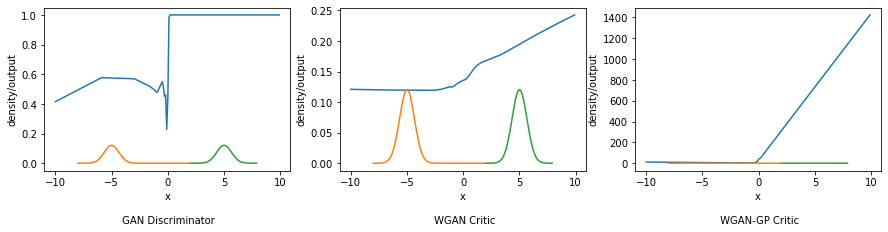

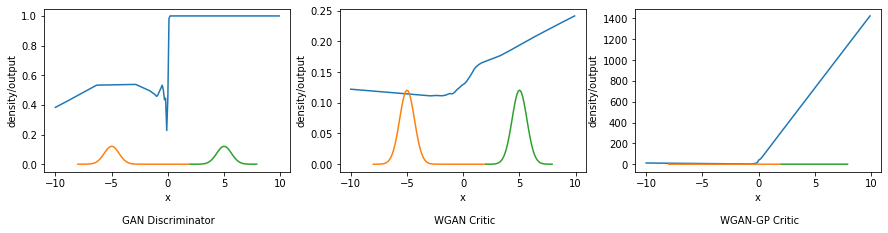

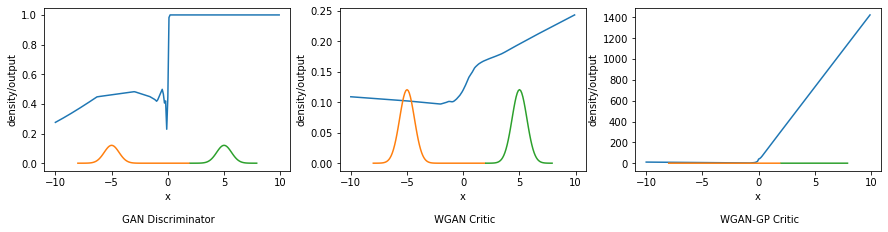

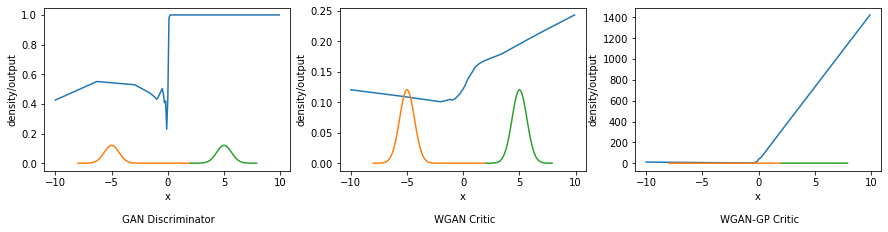

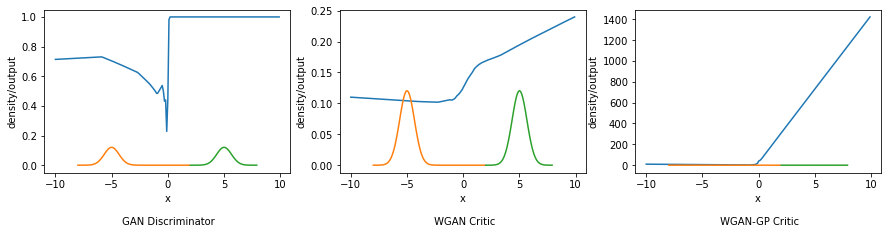

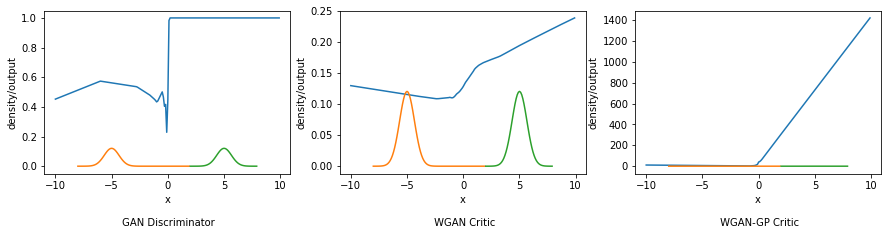

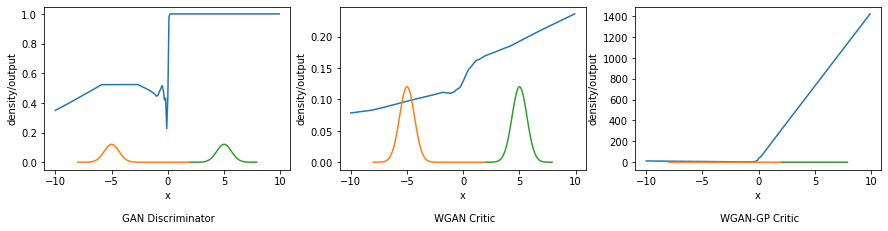

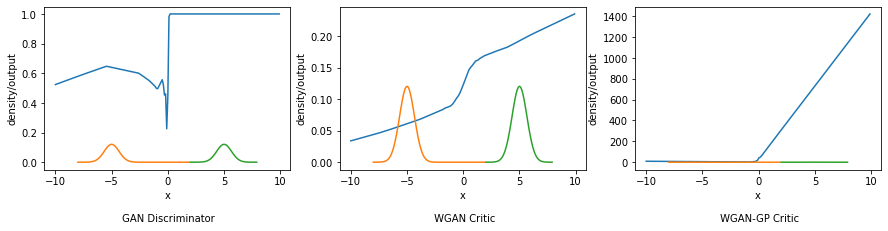

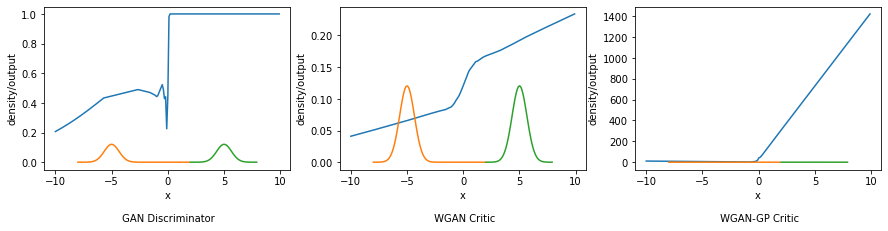

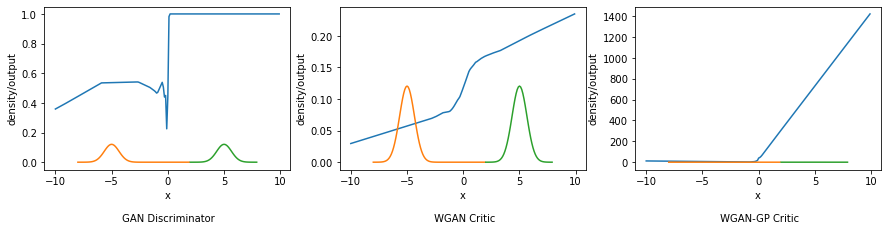

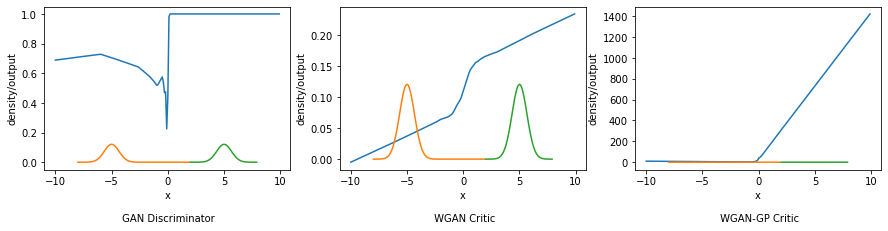

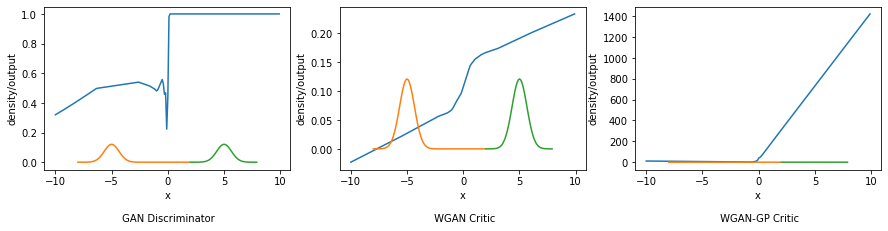

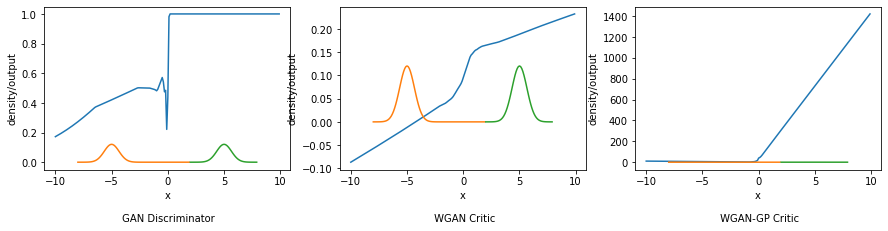

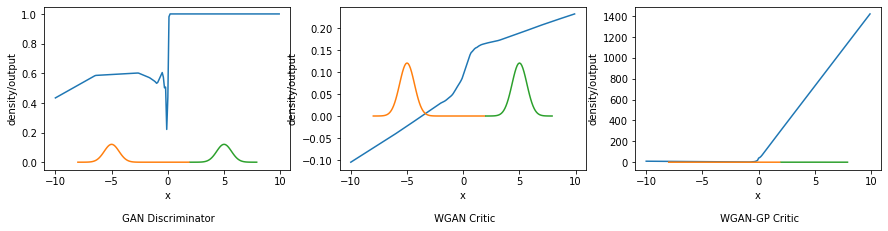

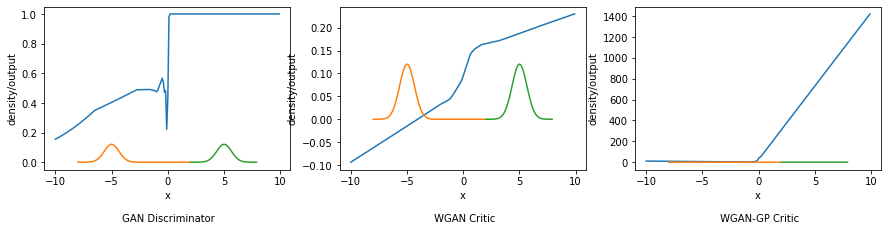

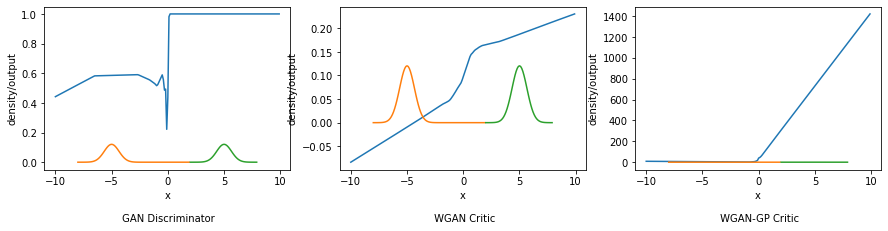

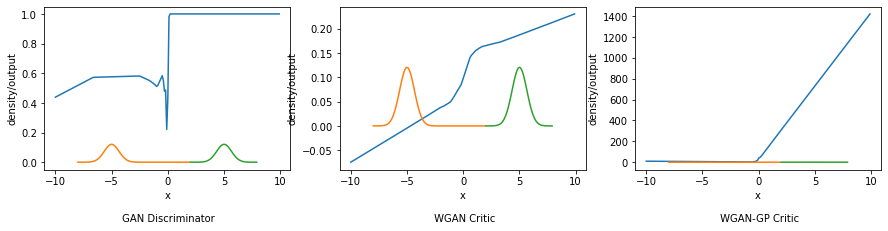

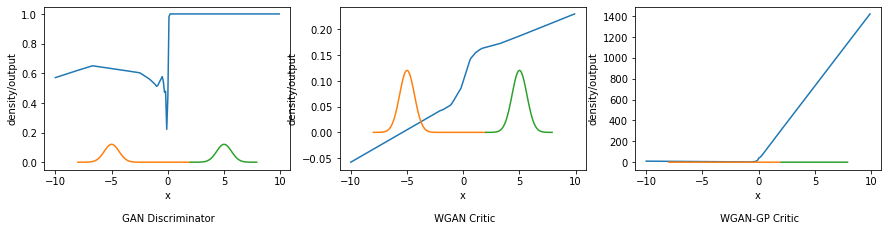

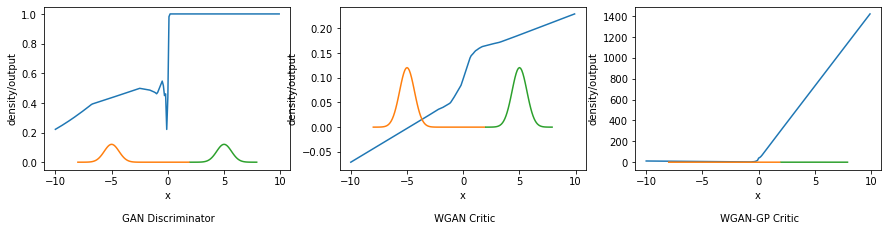

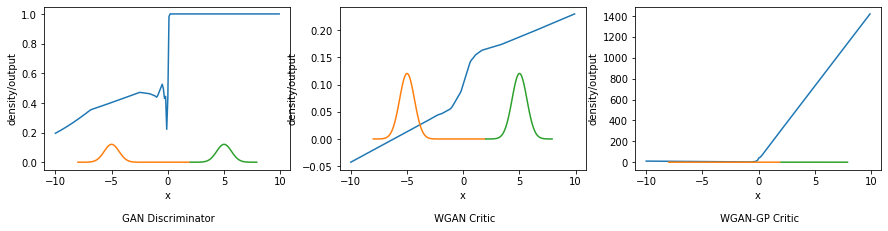

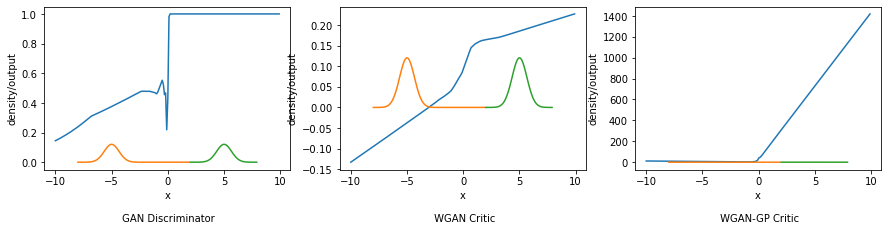

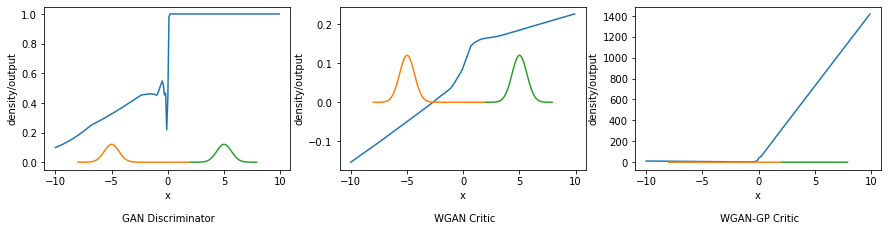

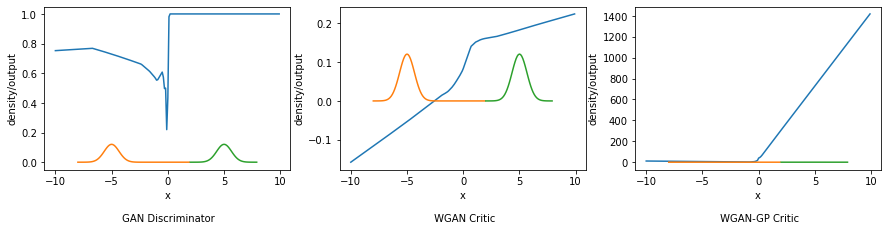

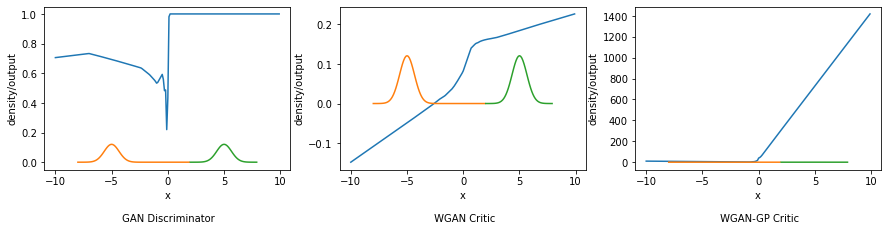

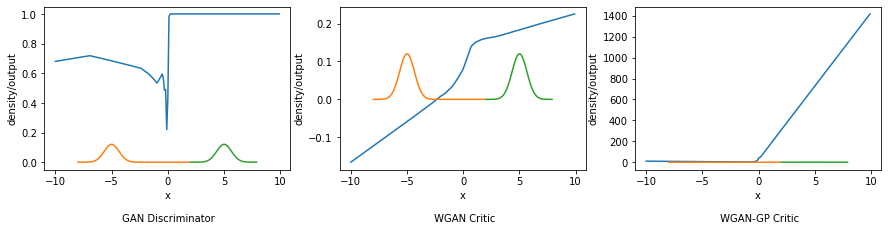

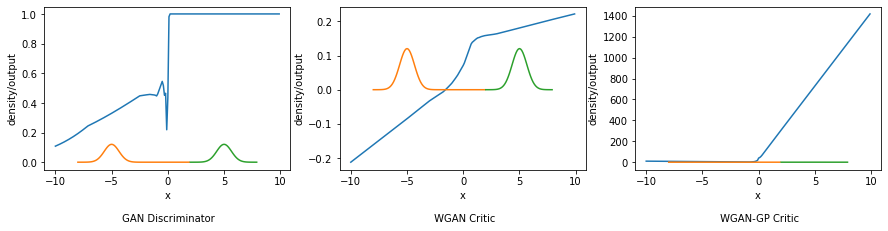

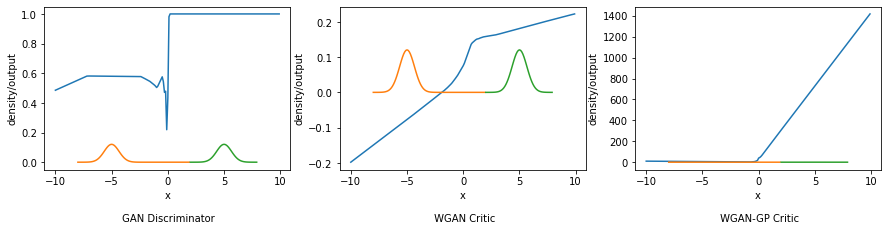

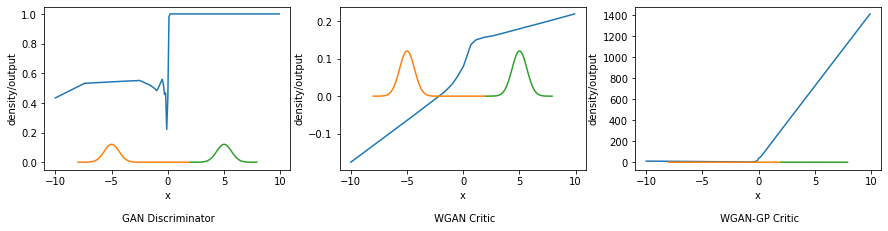

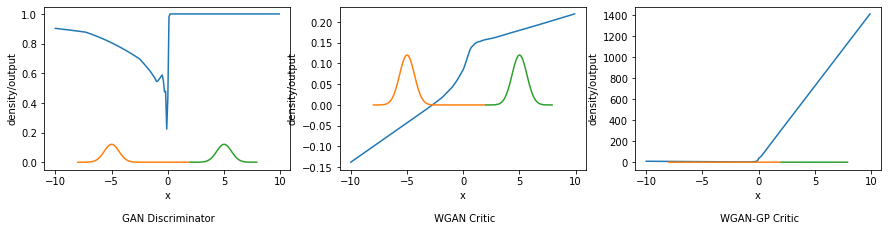

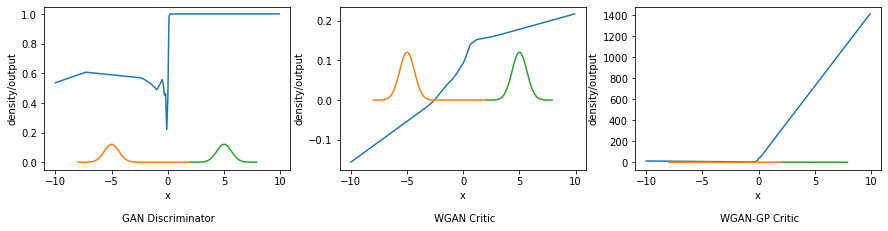

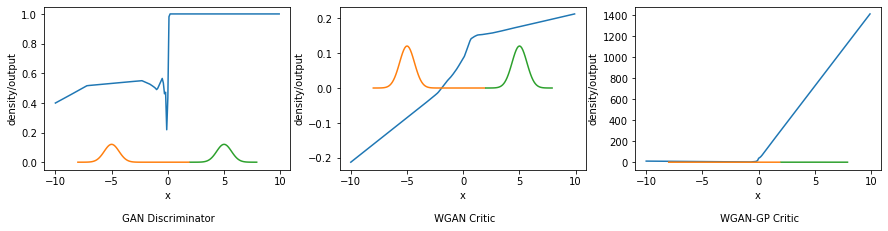

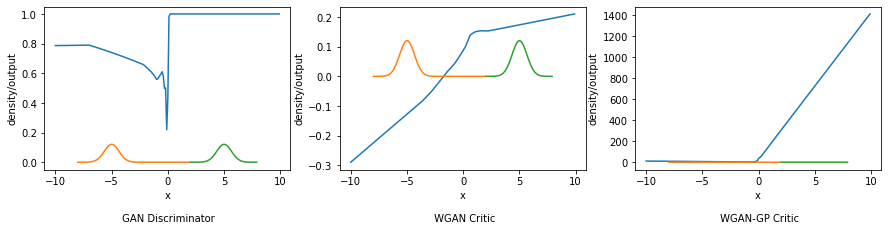

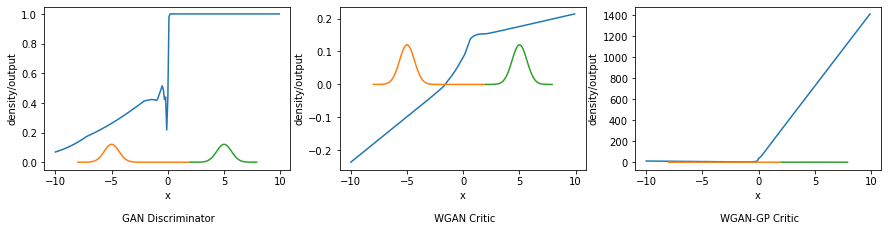

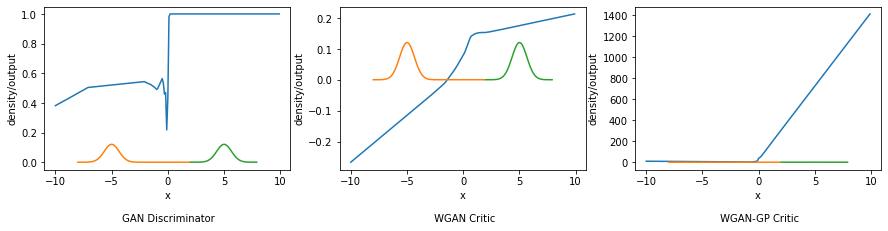

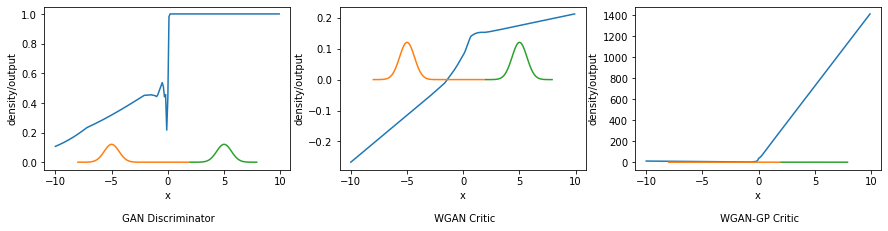

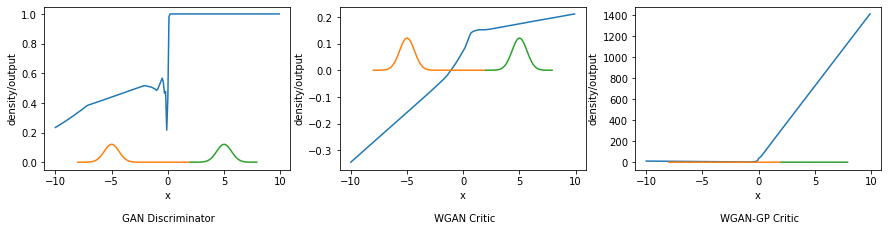

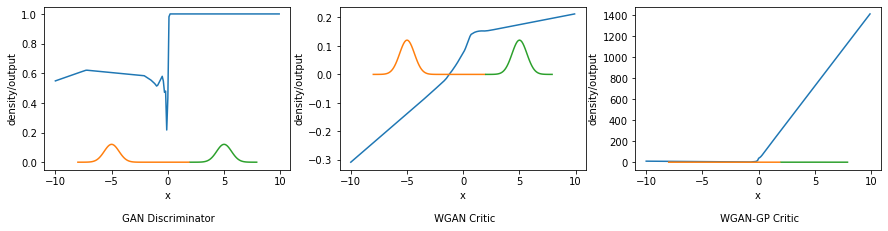

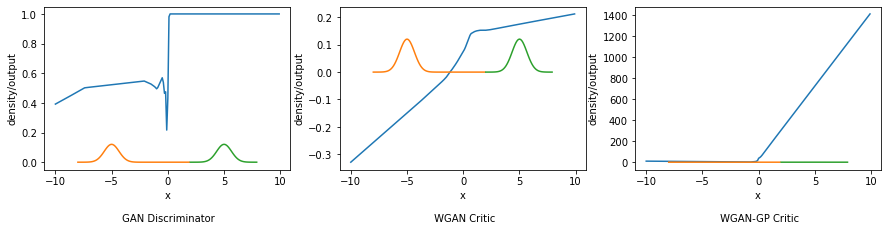

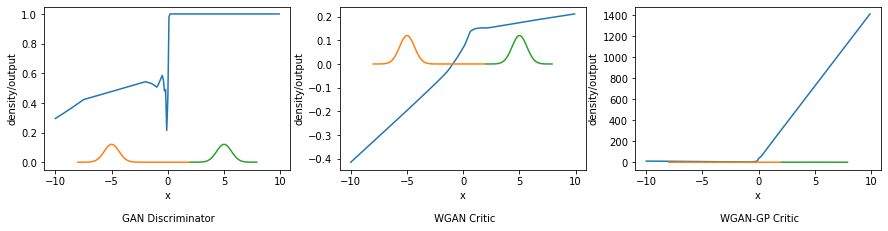

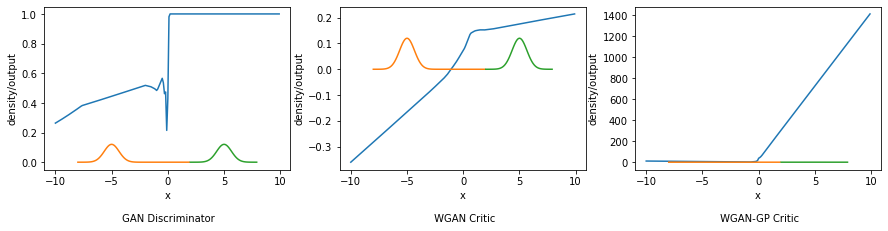

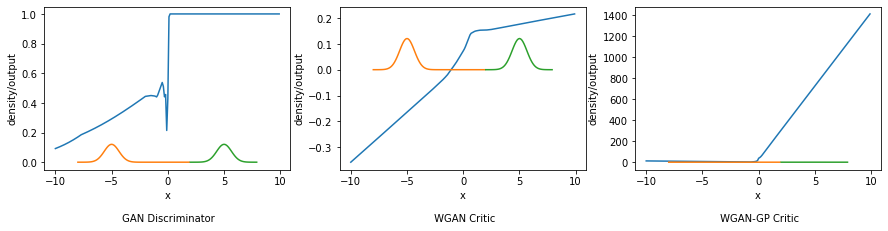

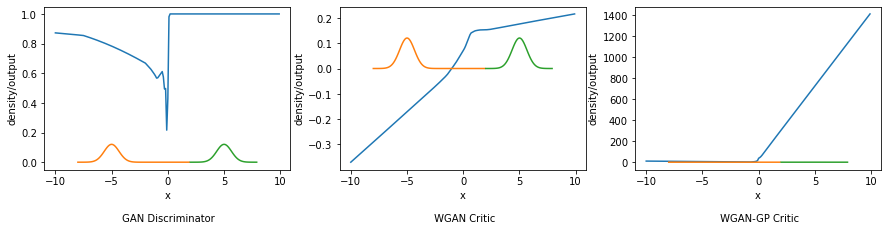

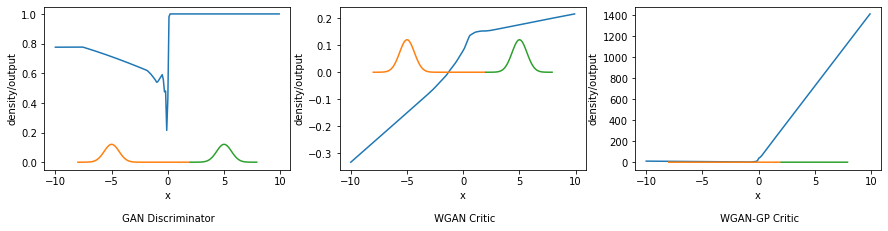

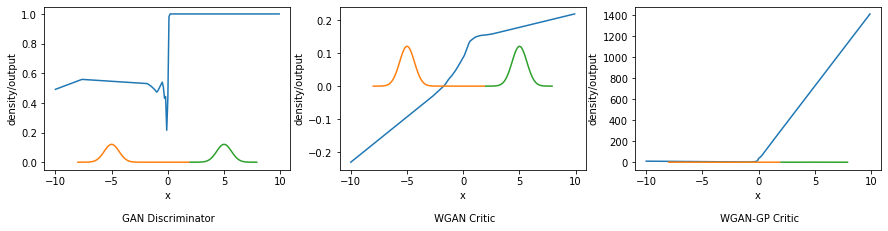

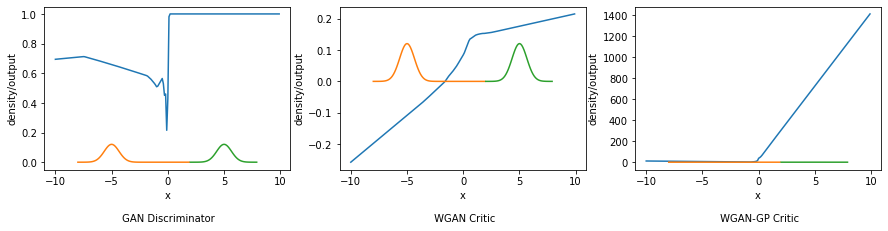

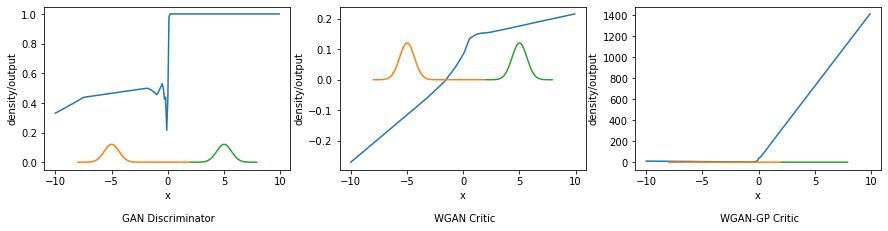

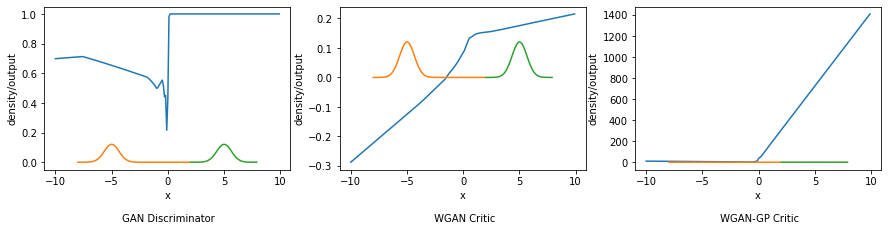

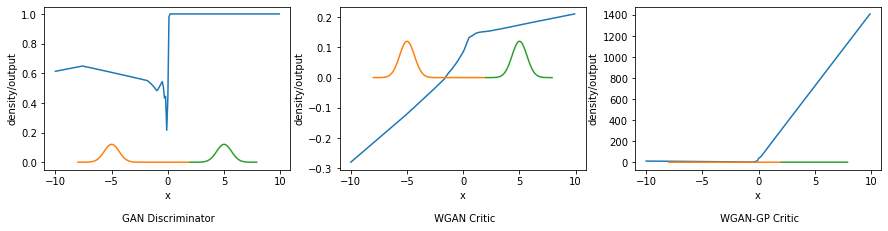

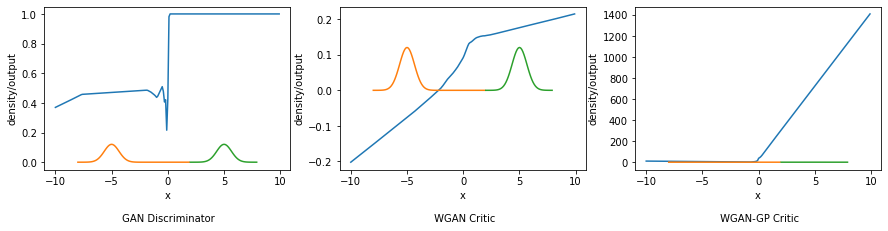

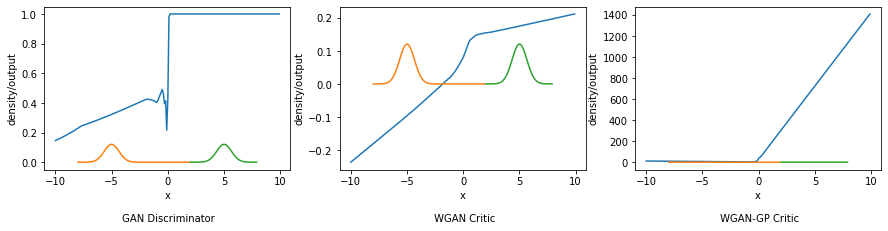

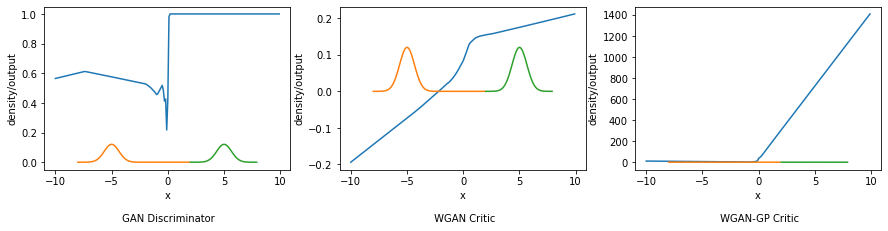

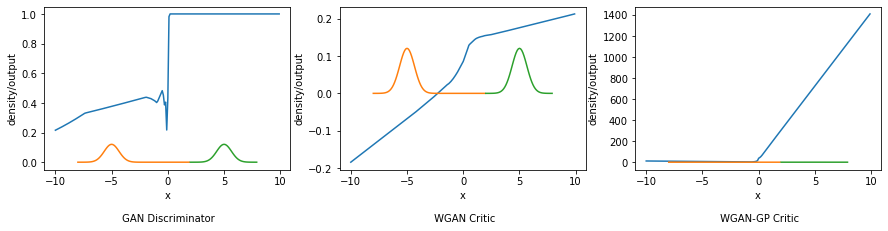

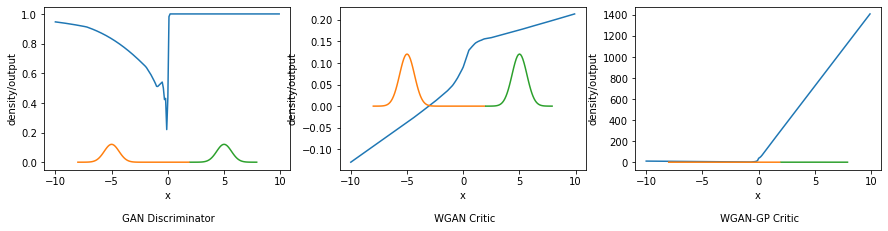

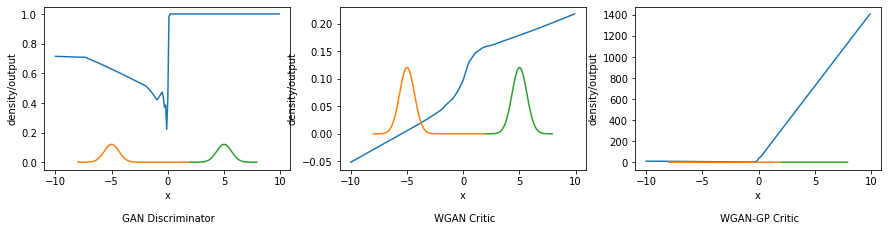

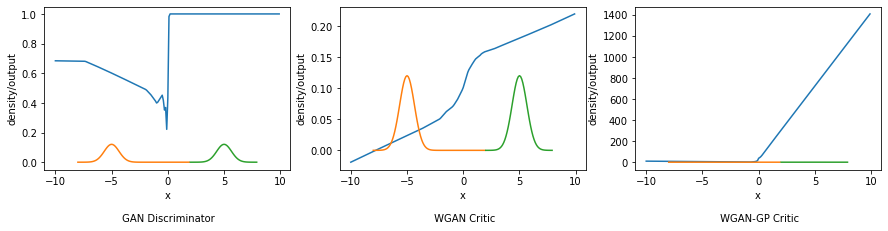

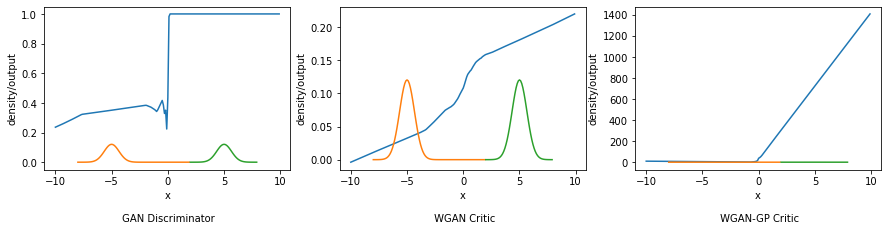

KeyboardInterrupt: 

In [83]:
### Training:
num_epoch = 10000
batch_size = 16
counter = 0

# Graphical evaluation at the beginning:
# Graphical evaluation:
with torch.no_grad():
    fig  = plt.figure(figsize=(15,3))
    ax = fig.add_subplot(131)
    ax.plot(torch.arange(-10,10,0.1), discriminator_gan(torch.arange(-10,10,0.1).reshape(-1,1)).detach().numpy())
    ax.plot(np.arange(-8,2,0.1), 10**torch.distributions.normal.Normal(-5,1).log_prob(torch.arange(-8,2,0.1)).detach().numpy())
    ax.plot(np.arange(2,8,0.1), 10**torch.distributions.normal.Normal(5,1).log_prob(torch.arange(2,8,0.1)).detach().numpy())
    ax.set_xlabel("x\n\n GAN Discriminator")
    ax.set_ylabel("density/output")
    ax = fig.add_subplot(132)
    ax.plot(torch.arange(-10,10,0.1), discriminator_wgan(torch.arange(-10,10,0.1).reshape(-1,1)).detach().numpy())
    ax.plot(np.arange(-8,2,0.1), 10**torch.distributions.normal.Normal(-5,1).log_prob(torch.arange(-8,2,0.1)).detach().numpy())
    ax.plot(np.arange(2,8,0.1), 10**torch.distributions.normal.Normal(5,1).log_prob(torch.arange(2,8,0.1)).detach().numpy())
    ax.set_xlabel("x\n\n WGAN Critic")
    ax.set_ylabel("density/output")
    ax = fig.add_subplot(133)
    ax.plot(torch.arange(-10,10,0.1), discriminator_wgan_gp(torch.arange(-10,10,0.1).reshape(-1,1)).detach().numpy())
    #ax.legend(["GAN Discriminator", "WGAN Critic", "WGAN-GP Critic"], loc = 'upper left')
    ax.plot(np.arange(-8,2,0.1), 10**torch.distributions.normal.Normal(-5,1).log_prob(torch.arange(-8,2,0.1)).detach().numpy())
    ax.plot(np.arange(2,8,0.1), 10**torch.distributions.normal.Normal(5,1).log_prob(torch.arange(2,8,0.1)).detach().numpy())
    ax.set_xlabel("x\n\n WGAN-GP Critic")
    ax.set_ylabel("density/output")
    plt.show()

    fig.savefig("/Users/Florian-Kuhm/Documents/images/image_" + str(counter) + ".png")
    counter += 1






for epoch in range(0, num_epoch):

    for iter in range(0, int(np.floor(data.shape[0]/batch_size))):

        # Reset all gradients:
        opt_disc_gan.zero_grad()
        opt_disc_wgan.zero_grad()
        opt_disc_wgan_gp.zero_grad()

        # Sample a batch:
        data = torch.concat((torch.normal(size=(batch_size//2,1), mean = -5, std = 1),torch.normal(size=(batch_size//2,1), mean = -5, std = 1)))
        label = torch.concat((torch.zeros(size=(batch_size//2,1)), torch.ones(size=(batch_size//2,1))))
        
        ###########################################################################
        # Train GAN Discriminator:
        outp_fake = discriminator_gan(data[:(batch_size//2)])
        outp_real = discriminator_gan(data[(batch_size//2):])
        loss_fake = bce(outp_fake, torch.zeros_like(outp_fake)).backward()
        loss_real = bce(outp_real, torch.ones_like(outp_real)).backward()
        
        opt_disc_gan.step()

        ###########################################################################
        # Train WGAN Critic:
        outp_fake = discriminator_wgan(data[:(batch_size//2)]).mean()
        outp_real = discriminator_wgan(data[(batch_size//2):]).mean()

        loss = -outp_real + outp_fake
        loss.backward()
        opt_disc_wgan.step()
        # Weight Clipping:
        with torch.no_grad():
            for param in discriminator_wgan.parameters():
                param.clamp_(-1, 1)
        

        ###########################################################################
        # Train WGAN-GP Critic:
        loss_real = discriminator_wgan_gp(data[:(batch_size//2)]).mean().backward(torch.tensor(-1, dtype=torch.float))
        loss_fake = discriminator_wgan_gp(data[(batch_size//2):]).mean().backward(torch.tensor(1, dtype=torch.float))

        # Use interpolation to generate an image:
        epsilon = torch.rand(size = (batch_size//2,1))
        x_hat = (data[:(batch_size//2)].mul(epsilon) + data[(batch_size//2):].mul(1-epsilon))
        x_hat = autograd.Variable(x_hat, requires_grad=True)

        loss = wlossGrad(
                autograd.grad(inputs = x_hat, outputs = discriminator_wgan_gp(x_hat), grad_outputs = torch.ones(size = (batch_size//2,1)),
                create_graph=True, retain_graph=True, only_inputs=True)[0]).backward()
        
        opt_disc_wgan_gp.step()


    if epoch%10 == 0:
        # Graphical evaluation:
        with torch.no_grad():
            fig  = plt.figure(figsize=(15,3))
            ax = fig.add_subplot(131)
            ax.plot(torch.arange(-10,10,0.1), discriminator_gan(torch.arange(-10,10,0.1).reshape(-1,1)).detach().numpy())
            ax.plot(np.arange(-8,2,0.1), 10**torch.distributions.normal.Normal(-5,1).log_prob(torch.arange(-8,2,0.1)).detach().numpy())
            ax.plot(np.arange(2,8,0.1), 10**torch.distributions.normal.Normal(5,1).log_prob(torch.arange(2,8,0.1)).detach().numpy())
            ax.set_xlabel("x\n\n GAN Discriminator")
            ax.set_ylabel("density/output")
            ax = fig.add_subplot(132)
            ax.plot(torch.arange(-10,10,0.1), discriminator_wgan(torch.arange(-10,10,0.1).reshape(-1,1)).detach().numpy())
            ax.plot(np.arange(-8,2,0.1), 10**torch.distributions.normal.Normal(-5,1).log_prob(torch.arange(-8,2,0.1)).detach().numpy())
            ax.plot(np.arange(2,8,0.1), 10**torch.distributions.normal.Normal(5,1).log_prob(torch.arange(2,8,0.1)).detach().numpy())
            ax.set_xlabel("x\n\n WGAN Critic")
            ax.set_ylabel("density/output")
            ax = fig.add_subplot(133)
            ax.plot(torch.arange(-10,10,0.1), discriminator_wgan_gp(torch.arange(-10,10,0.1).reshape(-1,1)).detach().numpy())
            #ax.legend(["GAN Discriminator", "WGAN Critic", "WGAN-GP Critic"], loc = 'upper left')
            ax.plot(np.arange(-8,2,0.1), 10**torch.distributions.normal.Normal(-5,1).log_prob(torch.arange(-8,2,0.1)).detach().numpy())
            ax.plot(np.arange(2,8,0.1), 10**torch.distributions.normal.Normal(5,1).log_prob(torch.arange(2,8,0.1)).detach().numpy())
            ax.set_xlabel("x\n\n WGAN-GP Critic")
            ax.set_ylabel("density/output")
            plt.show()

            fig.savefig("/Users/Florian-Kuhm/Documents/images/image_" + str(counter) + ".png")
            counter += 1
        
        